# Sparkify Project - Data Analysis

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This notebook loads and cleans the data and conducts exploratory data analysis. This is the basis for the feature selection and the final modeling.

In [103]:
# import libraries
import datetime
import pyspark.sql.functions as F
from dateutil import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, desc, udf, count
from pyspark.sql.types import IntegerType, TimestampType

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Here we will check for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load the mini dataset
events = spark.read.json("data/mini_sparkify_event_data.json")

In [4]:
# inspecting the schema
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# print 5 logged events from the dataset
events.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
events.dtypes # data types

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

The datatypes are as expected. No need to transform e.g. a string column into a numerical column

In [262]:
# let's see what we get as general statistics already
events.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+--------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|               churn|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+--------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|       

In [8]:
# look at portion of null values
for column in events.columns:
    print("Column {} has {} null values.".format(column, events.select(column).where(col(column).isNull()).count()))

Column artist has 58392 null values.
Column auth has 0 null values.
Column firstName has 8346 null values.
Column gender has 8346 null values.
Column itemInSession has 0 null values.
Column lastName has 8346 null values.
Column length has 58392 null values.
Column level has 0 null values.
Column location has 8346 null values.
Column method has 0 null values.
Column page has 0 null values.
Column registration has 8346 null values.
Column sessionId has 0 null values.
Column song has 58392 null values.
Column status has 0 null values.
Column ts has 0 null values.
Column userAgent has 8346 null values.
Column userId has 0 null values.


In [103]:
# let's look at some entries for one specific user to get a better understanding of the logs
events.select(["userId", "firstname", "page", "song", "level"]).where(events.userId == "30").collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Rockpools', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Time For Miracles', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)', level='paid'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', song=None, level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Fuck Kitty', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Jade', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='So-Called Friends', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Represent', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Here I Am', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Rebirthing (Album

### User ID

In [20]:
# inspect the userIds
events.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



The userId contains no null values but values with an empty string.

In [10]:
events.where(col("userId") == "").show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

Logs where the userId is an empty string belong to users who are not logged in. Because these logs belong to several users and it is not possible to track down the relation, we have to remove these logs.

In [11]:
# events where a userId is an empty string are not valid, remove these
valid_events = events.where(col("userId") != "")
print("Number of total events: {}; number of valid events {}".format(events.count(), valid_events.count()))

Number of total events: 286500; number of valid events 278154


### Page

In [23]:
# inspect page options
valid_events.select("page").dropDuplicates().sort("page").collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Login'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Register'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Registration'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

The page column contains the action "Cancellation Confirmation". This information can be later used to define churn.

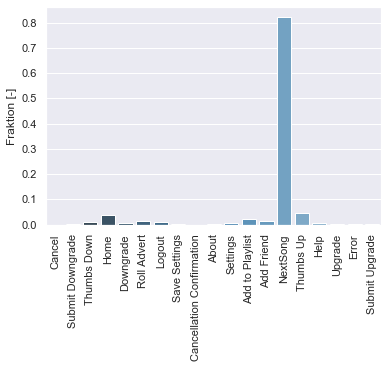

In [122]:
# visualize distribution of logs for page
page_counts = valid_events.groupBy("page").count().toPandas()
total_counts = page_counts["count"].sum()
page_counts["relative_count"] = page_counts["count"] / total_counts
fig, ax1 = plt.subplots()
sns.barplot(x="page", y="relative_count", data=page_counts,
                 palette="Blues_d", ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel("Fraktion [-]")
plt.xticks(rotation=90); # rotate ticks for readability

### Gender

In [25]:
# inspect gender options
valid_events.select("gender").dropDuplicates().sort("gender").collect()

[Row(gender='F'), Row(gender='M')]

Once the guest logs are removed, we also do not have any null values in the gender column anymore. The previous number of null value was also the same for firstName, lastName, location, registration and userAgent. Hence, we can assume that these columns also not have null values anymore.

### Level

In [26]:
# inspect level values
valid_events.select("level").dropDuplicates().sort("level").collect()

[Row(level='free'), Row(level='paid')]

### Registration and ts

In [36]:
# registration and ts can both be converted to timestamps
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType()) # udf to convert to timestamp/date

In [37]:
valid_events = valid_events.withColumn("registration_date", get_date(col("registration"))) # date for registration
valid_events.select("registration_date").show()

+-------------------+
|  registration_date|
+-------------------+
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-29 00:22:42|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-19 15:53:39|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
+-------------------+
only showing top 20 rows



In [38]:
valid_events = valid_events.withColumn("log_date", get_date(col("ts"))) # date when the log entry was done
valid_events.select("log_date").show()

+-------------------+
|           log_date|
+-------------------+
|2018-10-01 02:01:57|
|2018-10-01 02:03:00|
|2018-10-01 02:06:34|
|2018-10-01 02:06:56|
|2018-10-01 02:11:16|
|2018-10-01 02:11:18|
|2018-10-01 02:14:46|
|2018-10-01 02:14:59|
|2018-10-01 02:15:05|
|2018-10-01 02:18:04|
|2018-10-01 02:19:06|
|2018-10-01 02:19:10|
|2018-10-01 02:20:18|
|2018-10-01 02:22:55|
|2018-10-01 02:22:56|
|2018-10-01 02:24:01|
|2018-10-01 02:26:16|
|2018-10-01 02:27:48|
|2018-10-01 02:28:07|
|2018-10-01 02:29:04|
+-------------------+
only showing top 20 rows



### Status

In [31]:
# inspect the status values
valid_events.select("status").dropDuplicates().sort("status").collect()

[Row(status=200), Row(status=307), Row(status=404)]

In [264]:
valid_events.where(col("status") == 404).take(5)

[Row(artist=None, auth='Logged In', firstName='Kael', gender='M', itemInSession=48, lastName='Baker', length=None, level='paid', location='Kingsport-Bristol-Bristol, TN-VA', method='GET', page='Error', registration=1533102330000, sessionId=249, song=None, status=404, ts=1538393848000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='131', churn=0, registration_date=datetime.datetime(2018, 8, 1, 7, 45, 30), log_date=datetime.datetime(2018, 10, 1, 13, 37, 28), log_event_year=2018, log_event_month=10),
 Row(artist=None, auth='Logged In', firstName='Lucero', gender='F', itemInSession=10, lastName='Reed', length=None, level='free', location='Louisville/Jefferson County, KY-IN', method='GET', page='Error', registration=1536642109000, sessionId=139, song=None, status=404, ts=1538407927000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari

Status 404 actually seems to be an error. That is also what the page value indicates.

In [123]:
valid_events.where(col("status") == 307).take(5)

[Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=86, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='Thumbs Up', registration=1538331630000, sessionId=8, song=None, status=307, ts=1538353376000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', churn=0, downgrade_event=0, registration_date=datetime.datetime(2018, 9, 30, 20, 20, 30), log_date=datetime.datetime(2018, 10, 1, 2, 22, 56)),
 Row(artist=None, auth='Logged In', firstName='Alexi', gender='F', itemInSession=7, lastName='Warren', length=None, level='paid', location='Spokane-Spokane Valley, WA', method='PUT', page='Thumbs Up', registration=1532482662000, sessionId=53, song=None, status=307, ts=1538355255000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', userId='54', churn=0, downgrade_event=0, registration_date=datet

In [267]:
valid_events.select("status") \
     .groupBy("status") \
     .agg({'status' : 'count'}) \
     .withColumnRenamed('count(status)', 'Statuscount') \
     .sort(desc('Statuscount')) \
     .show()

+------+-----------+
|status|Statuscount|
+------+-----------+
|   200|     254718|
|   307|      23184|
|   404|        252|
+------+-----------+



Status:
- 404: Page not found
- 307: Temporary redirect
- 200: OK

### Length

In [13]:
valid_events.where(col("length").isNull()).count()

50046

The length, artist and song column still have null values.

In [268]:
# inspect the length values
valid_events.select("length").dropDuplicates().sort("length").show(30)

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
|12.43383|
|12.64281|
|12.66893|
|12.69506|
|13.16526|
|13.42649|
|13.63546|
|13.68771|
|13.92281|
|14.96771|
+--------+
only showing top 30 rows



In [269]:
# statistics about the length
valid_events.select("length").describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [49]:
# when is the length null
valid_events.where(col("length").isNull()).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|  registration_date|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|    0|2018-09-29 00:22:42|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|15383

In [51]:
# are there entries where the log contains null for the length but the artist is not null
valid_events.where(col("artist").isNotNull() & col("length").isNull()).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|churn|registration_date|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+



In [52]:
# what action happend when the length is not null
valid_events.where(col("length").isNotNull()).groupBy("page").count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



This illustrates that the length clearly describes how long the user listened to a specific song.

### Artist

In [58]:
# let's look at the artists and songs
valid_events.select("artist").dropDuplicates().sort("artist").show(30)

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|            10 Years|
|       10000 Maniacs|
|           1000names|
|                1001|
|                 108|
|      10_000 Maniacs|
|                10cc|
|                 112|
+--------------------+
only showing top 30 rows



In [60]:
valid_events.filter(col("artist") == "!!!").show()

+------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-----+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|            song|status|           ts|           userAgent|userId|churn|  registration_date|
+------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-----+-------------------+
|   !!!|Logged In|    Faigy|     F|          319|    Howe|294.94812| paid|Phoenix-Mesa-Scot...|   PUT|NextSong|1538211832000|      398|      A New Name|   200|1538653371000|Mozilla/5.0 (Maci...|    95|    0|2018-09-29 11:03:52|
|   !!!|Logged In|  Nikolas|     M|           12|   Olsen|356.10077| paid|Oxnard-Thousan

"!!!" is really an artist. You can look it up on spotify (https://open.spotify.com/artist/1mmehjf7eHA10uHMisZGJg).

### Song

In [61]:
valid_events.select("song").dropDuplicates().sort("song").show(30)

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
|&And The Battle B...|
|&And The Day Turn...|
|&And The World Wi...|
|&and She Told Me ...|
|        ' Cello Song|
|           '60 - '65|
|  '97 Bonnie & Clyde|
|            'A Cimma|
|'Allo 'Allo (Orig...|
|  'Elepaio Slack Key|
+--------------------+
only showing top 30 rows



Songs and artist contain null values as expected but no further processing necessary here. Whenever the length, artist and song are null, this log is not related to playing music.

### First and last name

In [64]:
# firstName, lastName
valid_events.select("firstName").dropDuplicates().sort("firstName").show(30)

+----------+
| firstName|
+----------+
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
|   Alyssia|
| Amberlynn|
|    Andrew|
|     Angel|
|     Anika|
|      Anna|
| Annabella|
|  Antonina|
|   Antonio|
|      Aron|
|   Ashlynn|
|    Aurora|
|    Autumn|
|       Ava|
|    Azrael|
|  Benjamin|
|    Bianca|
|   Brayden|
|     Brisa|
|    Brooke|
+----------+
only showing top 30 rows



In [63]:
# any null values for first or last name
valid_events.where(col("firstName").isNull() | col("lastName").isNull()).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|churn|registration_date|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+



First and last name do not contain any null values anymore. 

### Auth

In [65]:
# inspect the auth data
valid_events.select("auth").dropDuplicates().sort("auth").show(30)

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [77]:
# how do the logs look for the case that auth is cancelled
valid_events.filter(col("auth") == "Cancelled").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|  registration_date|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|    1|2018-08-30 12:04:26|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   

In [78]:
valid_events.filter(col("auth") == "Cancelled").filter(col("page") != "Cancellation Confirmation").show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|churn|registration_date|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+



If the cancellation is confirmed, the authentication is set to "cancelled".

### Method

In [66]:
# what do we get for the method values
valid_events.select("method").dropDuplicates().sort("method").show(30)

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



# Data Analysis for Churn
Now we define a variable for churn and also look into the data to find any differences between the users who churned and the ones who did not.

In [14]:
# add a column "churn" to the dataframe indicating that a cancellation was confirmed
find_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
valid_events = valid_events.withColumn("churn", find_churn(col("page")))
valid_events[["page", "churn"]].where(valid_events.churn == 1).show()

+--------------------+-----+
|                page|churn|
+--------------------+-----+
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
+--------------------+-----+
only showing top 20 rows



In [15]:
# we can also define downgrade to find the users who downgraded
find_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
valid_events = valid_events.withColumn("downgrade_event", find_downgrade(col("page")))
valid_events[["page", "downgrade_event"]].where(valid_events.downgrade_event == 1).show()

+----------------+---------------+
|            page|downgrade_event|
+----------------+---------------+
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
+----------------+---------------+
only showing top 20 rows



In [16]:
# group logs by user to figure out which users churned and/or downgraded
users = valid_events.groupBy("userId").agg({"churn": "sum", "downgrade_event": "sum"}).withColumnRenamed("sum(churn)", "churned").withColumnRenamed("sum(downgrade_event)", "downgraded")  

In [17]:
users.describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|        downgraded|           churned|
+-------+------------------+------------------+------------------+
|  count|               225|               225|               225|
|   mean|65391.013333333336|              0.28|0.2311111111111111|
| stddev|105396.47791907164|0.5876709477736184|0.4224832108996327|
|    min|                10|                 0|                 0|
|    max|                99|                 3|                 1|
+-------+------------------+------------------+------------------+



In [18]:
# showing how many users churned
users.groupBy("churned").count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  173|
|      1|   52|
+-------+-----+



The mini dataset contains 225 users, only 52 of them churned and 173 did not. This indicates that the dataset is imbalanced.

In [19]:
users.groupBy(["downgraded", "churned"]).count().show()

+----------+-------+-----+
|downgraded|churned|count|
+----------+-------+-----+
|         3|      0|    2|
|         1|      0|   28|
|         1|      1|    9|
|         0|      1|   43|
|         2|      0|   10|
|         0|      0|  133|
+----------+-------+-----+



Users can downgrade several times. This is why the numbers 2 and 3 also appear in the aggreagated dataframe above. From the users who downgraded once, most of them did not churn. But from the users who did not downgrade, 43 churned and 133 did not churn.

In [20]:
# obtain average length one user listens to a song
user_length = valid_events.groupBy("userId").agg({"churn": "sum", "length": "mean"}).withColumnRenamed("avg(length)", "avg_length")

In [21]:
user_length.where(col("sum(churn)") == 1).describe().show()

+-------+-----------------+----------+------------------+
|summary|           userId|sum(churn)|        avg_length|
+-------+-----------------+----------+------------------+
|  count|               52|        52|                52|
|   mean|80808.42307692308|       1.0| 248.3078649624796|
| stddev| 86381.6770659117|       0.0| 7.703952015262295|
|    min|           100001|         1|225.18811730769232|
|    max|               87|         1|267.76714199999986|
+-------+-----------------+----------+------------------+



In [22]:
user_length.where(col("sum(churn)") == 0).describe().show()

+-------+------------------+----------+------------------+
|summary|            userId|sum(churn)|        avg_length|
+-------+------------------+----------+------------------+
|  count|               173|       173|               173|
|   mean| 60756.87861271676|       0.0|249.14125354064802|
| stddev|110276.04376677402|       0.0| 5.312185141455677|
|    min|                10|         0|230.55628000000002|
|    max|                99|         0| 267.2713832911391|
+-------+------------------+----------+------------------+



Regarding the average length the users listen to music there is not a big difference to observe, except that the standard deviation for the users who did not churn is smaller.

In [126]:
# count the logged events per group
valid_events.groupBy("userId").agg(F.sum("churn").alias("churned"), F.count("page").alias("events")).groupBy("churned").agg(F.sum("events").alias("events")).show()

+-------+------+
|churned|events|
+-------+------+
|      0|233290|
|      1| 44864|
+-------+------+



In [23]:
# investigate the distribution of the logs regarding the level of the users
event_count = valid_events \
     .groupBy(["level", "userId"]) \
     .count()

In [88]:
event_count.show()

+-----+------+-----+
|level|userId|count|
+-----+------+-----+
| paid|   101| 2073|
| free|    43|  240|
| paid|   152| 1403|
| paid|300021| 4650|
| free|     6|   84|
| free|    52|  346|
| free|   117|  445|
| paid|200009|  543|
| free|    74|  369|
| free|    30| 1100|
| paid|   147|  467|
| free|200008|   24|
| paid|200017|  399|
| free|    87|  851|
| paid|    81| 2294|
| free|    66|  435|
| paid|   139|  421|
| paid|    42| 4128|
| paid|   106|  873|
| paid|    37| 1603|
+-----+------+-----+
only showing top 20 rows



In [24]:
event_count.groupBy("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



In [25]:
# how active are these differnt user groups
event_count.groupBy("level").sum().show()

+-----+----------+
|level|sum(count)|
+-----+----------+
| free|     55721|
| paid|    222433|
+-----+----------+



There are 165 paid users and 195 free users. However, there are rughly 4 times more logged events for paid users than for free users. Paid users use sparkify much more often.

In [26]:
# is there a difference in the churn rate when considering the level
group_level_user = valid_events.groupBy(["userId", "level"]).agg({"churn": "sum"}).withColumnRenamed("sum(churn)", "churned")

In [27]:
group_level_user.show()

+------+-----+-------+
|userId|level|churned|
+------+-----+-------+
|100021| free|      1|
|200021| free|      0|
|200001| free|      1|
|     6| free|      0|
|300022| paid|      0|
|   132| free|      0|
|   112| free|      0|
|    79| free|      0|
|200008| free|      0|
|    16| paid|      0|
|200007| paid|      0|
|300015| free|      0|
|    39| free|      0|
|300014| paid|      0|
|    61| free|      0|
|    56| paid|      0|
|300014| free|      0|
|   100| paid|      0|
|300024| paid|      0|
|300023| paid|      0|
+------+-----+-------+
only showing top 20 rows



In [28]:
group_level_user.groupBy(["level", "churned"]).count().show()

+-----+-------+-----+
|level|churned|count|
+-----+-------+-----+
| free|      0|  174|
| paid|      0|  134|
| free|      1|   21|
| paid|      1|   31|
+-----+-------+-----+



The churning rate is higher for paid users. Users can submit a downgrade or submit an upgrade. These users can be in both groups. Hence, the sum of users in the grouped dataframe above is higher than the number of unique user ids.

In [29]:
# group the data also by gender
group_gender = valid_events.groupBy(["userId", "gender"]).agg({"churn": "sum"}).withColumnRenamed("sum(churn)", "churned")

In [30]:
group_gender.groupBy(["gender", "churned"]).count().show()

+------+-------+-----+
|gender|churned|count|
+------+-------+-----+
|     F|      0|   84|
|     F|      1|   20|
|     M|      0|   89|
|     M|      1|   32|
+------+-------+-----+



Almost equal distribution of the gender in both groups. However, the churning rate is slightly higher for males.

In [39]:
# some values can be set into relation to a certain time period, e.g. the duration the user is active
# hence we need to create a df with all users and their active time period
# first find the first and last log entry for each user and how much log entries exist per user (all actions)
time_df = valid_events.groupBy(["userId"]).agg(F.sum("churn").alias("churned"), F.min("log_date").alias("first_log"), F.max("log_date").alias("last_log"), F.count("page").alias("log_counts"))

In [40]:
time_df.show()

+------+-------+-------------------+-------------------+----------+
|userId|churned|          first_log|           last_log|log_counts|
+------+-------+-------------------+-------------------+----------+
|100010|      0|2018-10-08 14:58:54|2018-11-21 19:12:32|       381|
|200002|      0|2018-10-01 13:30:30|2018-11-16 00:25:54|       474|
|   125|      1|2018-10-12 06:05:44|2018-10-12 06:35:18|        11|
|    51|      1|2018-10-01 14:57:12|2018-10-17 09:39:32|      2464|
|   124|      0|2018-10-01 17:17:10|2018-11-30 16:12:46|      4825|
|     7|      0|2018-10-03 13:57:49|2018-11-23 07:46:51|       201|
|    54|      1|2018-10-01 02:32:10|2018-11-12 20:40:08|      3437|
|    15|      0|2018-10-01 12:23:35|2018-11-25 05:56:58|      2278|
|   155|      0|2018-11-02 16:56:25|2018-11-28 12:48:30|      1002|
|   132|      0|2018-10-02 10:59:56|2018-11-21 21:56:12|      2304|
|   154|      0|2018-11-02 16:15:35|2018-11-27 15:56:05|       118|
|100014|      1|2018-10-10 15:12:16|2018-11-20 2

In [42]:
def get_time_difference(date_1, date_2):
    """TODO"""
    # difference between the dates
    delta = date_2 - date_1
    
    # minimum difference is one 1
    if delta.days == 0:
        return 1
    else:
        return delta.days

# create a udf for this function
get_time_difference_udf = udf(get_time_difference, IntegerType())

# append the duration (in days) each user was or is registered
time_df = time_df.withColumn("duration", get_time_difference_udf(col("first_log"), col("last_log")))
time_df.show()

+------+-------+-------------------+-------------------+----------+--------+
|userId|churned|          first_log|           last_log|log_counts|duration|
+------+-------+-------------------+-------------------+----------+--------+
|100010|      0|2018-10-08 14:58:54|2018-11-21 19:12:32|       381|      44|
|200002|      0|2018-10-01 13:30:30|2018-11-16 00:25:54|       474|      45|
|   125|      1|2018-10-12 06:05:44|2018-10-12 06:35:18|        11|       1|
|    51|      1|2018-10-01 14:57:12|2018-10-17 09:39:32|      2464|      15|
|   124|      0|2018-10-01 17:17:10|2018-11-30 16:12:46|      4825|      59|
|     7|      0|2018-10-03 13:57:49|2018-11-23 07:46:51|       201|      50|
|    54|      1|2018-10-01 02:32:10|2018-11-12 20:40:08|      3437|      42|
|    15|      0|2018-10-01 12:23:35|2018-11-25 05:56:58|      2278|      54|
|   155|      0|2018-11-02 16:56:25|2018-11-28 12:48:30|      1002|      25|
|   132|      0|2018-10-02 10:59:56|2018-11-21 21:56:12|      2304|      50|

The first idea was to use months as time period, however in this data the first and last log never had a difference > 1 months.

In [43]:
# create a dummy dataframe where each action (About, Thumbs Up, ...) from page is a new column with the number
# how often this action appeared in the data for each user
dummy_df = valid_events.select("userId", "page").groupBy("userId").pivot("page").count()
# fill null values
dummy_df = dummy_df.na.fill(0)
dummy_df.first()

Row(userId='200002', About=3, Add Friend=4, Add to Playlist=8, Cancel=0, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, Logout=5, NextSong=387, Roll Advert=7, Save Settings=0, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2)

In [49]:
user_level = valid_events.orderBy("log_date", ascending=False).groupBy("userId").agg(F.first("level").alias('valid_level'))

In [50]:
user_gender = valid_events.select(["userId", "gender"]).distinct()

In [51]:
# calculate the total amount of days the user listened to music
songs_per_date = valid_events.withColumn("date", F.to_date(col("log_date"))).where(col("page") == "NextSong") \
    .groupBy(["userId", "date"]).agg(F.lit(1).alias("played_music"))
songs_per_day = songs_per_date.groupBy("userId").agg(F.sum("played_music").alias("music_days"))

In [52]:
# join user_df (time_df, dummy_df) with user_level and gender_level and user_length
df = time_df.join(dummy_df, on="userId").join(user_level, on="userId") \
    .join(user_gender, on="userId").join(user_length, on="userId").join(songs_per_day, on="userId")

In [53]:
# divide the actions by the amount of logs or the overall duration of their registration
def divide_columns_by(df, columns, value, appendix):
    """TODO"""
    for name in columns:
        new_name = name+"_"+appendix
        df = df.withColumn(new_name, col(name) / col(value))
    return df

In [54]:
cols_to_divide = ['music_days', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home',
               'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
               'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']

In [55]:
df_duration = divide_columns_by(df, cols_to_divide, "duration", "per_day")
user_df = divide_columns_by(df_duration, cols_to_divide, "log_counts", "per_log")

# Visualization

In [56]:
users = user_df.toPandas()

In [136]:
users.dtypes

userId                              object
churned                              int64
first_log                   datetime64[ns]
last_log                    datetime64[ns]
log_counts                           int64
duration                             int32
About                                int64
Add Friend                           int64
Add to Playlist                      int64
Downgrade                            int64
Error                                int64
Help                                 int64
Home                                 int64
Logout                               int64
NextSong                             int64
Roll Advert                          int64
Save Settings                        int64
Settings                             int64
Submit Downgrade                     int64
Submit Upgrade                       int64
Thumbs Down                          int64
Thumbs Up                            int64
Upgrade                              int64
valid_level

In [87]:
users.drop(["Cancel", "Cancellation Confirmation", "sum(churn)"], axis=1, inplace=True)
churned = users[users["churned"] == 1].select_dtypes(include=["int64", "int32", "float64"]) # users who churned
not_churned = users[users["churned"] == 0].select_dtypes(include=["int64", "int32", "float64"]) # users who did not

In [66]:
def create_hist_for_groups(churn_values, not_churn_values, x_label, ax1, ax2):
    """TODO!!!"""
    # mean values
    mean_churn = churn_values.mean()
    mean_not_churn = not_churn_values.mean()
    # histogram for churn values
    ax1.hist(churn_values, density=True)
    ax1.axvline(mean_churn, color='g', linestyle='dashed', linewidth=1, label="mean")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel("Normalized Count")
    ax1.set_title("Churned")
    ax1.legend()
    ax2.hist(not_churn_values, density=True)
    ax2.axvline(mean_not_churn, color='g', linestyle='dashed', linewidth=1, label="mean")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel("Normalized Count")
    ax2.set_title("Not Churned")
    ax2.legend()
    
    return ax1, ax2, mean_churn, mean_not_churn

In [90]:
def plot_data(churned, not_churned, var_names):
    n_cols = 4
    n_rows = round(2 * len(var_names) / n_cols + 0.5)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,100)) # create a figure for all subplots
    col_cnt = 0 # index for the column in the subplots
    row_cnt = 0 # index for the row in the subplots

    print("Churn Statistics for Dummy Variables")
    print("Churn \t\t\t | Not Churn \t\t | Diff \t\t | Variable")

    mean_churn_list, mean_not_churn_list, mean_diff_list = [], [], []

    # iterate over all variables
    for name in var_names:
        
        # create histograms and calculate the means
        axes[row_cnt, col_cnt], axes[row_cnt, col_cnt+1], mean_churn, mean_not_churn = create_hist_for_groups(
            churned[name], not_churned[name], name, axes[row_cnt, col_cnt], axes[row_cnt, col_cnt+1]
        )


        # check if we reached the next row
        col_cnt += 2
        if col_cnt >= n_cols:
            col_cnt = 0
            row_cnt += 1    

        # plot means and diff
        mean_diff = mean_churn - mean_not_churn
        print("%f \t\t %f \t\t %f \t\t %s" % (mean_churn, mean_not_churn, mean_diff, name))

        mean_churn_list.append(mean_churn)
        mean_not_churn_list.append(mean_not_churn)
        mean_diff_list.append(mean_diff)

    # add padding and show
    fig.tight_layout(h_pad=3.0, w_pad=1.5)
    plt.show()
    
    # create stylebar
    data = {'variable': var_names,
        'churn':  mean_churn_list,
        'not_churn': mean_not_churn_list,
        'diff': mean_diff_list
        }

    df = pd.DataFrame(data)
    df["relative_diff"] = round(100*((df["churn"] - df["not_churn"]) / df["not_churn"]), 2) # new - ref / ref
    styler = df.style.bar(subset=["relative_diff"], align='mid', color=['#d65f5f', '#5fba7d'])
    return styler

Churn Statistics for Dummy Variables
Churn 			 | Not Churn 		 | Diff 		 | Variable
862.769231 		 1348.497110 		 -485.727879 		 log_counts
23.211538 		 46.537572 		 -23.326034 		 duration
1.076923 		 2.537572 		 -1.460649 		 About
12.230769 		 21.046243 		 -8.815474 		 Add Friend
19.961538 		 31.722543 		 -11.761005 		 Add to Playlist
6.480769 		 9.930636 		 -3.449867 		 Downgrade
0.615385 		 1.271676 		 -0.656292 		 Error
4.596154 		 7.023121 		 -2.426968 		 Help
32.153846 		 48.612717 		 -16.458871 		 Home
10.634615 		 15.450867 		 -4.816252 		 Logout
699.884615 		 1108.173410 		 -408.288795 		 NextSong
18.596154 		 17.144509 		 1.451645 		 Roll Advert
1.115385 		 1.456647 		 -0.341263 		 Save Settings
5.192308 		 7.190751 		 -1.998444 		 Settings
0.173077 		 0.312139 		 -0.139062 		 Submit Downgrade
0.615385 		 0.734104 		 -0.118719 		 Submit Upgrade
9.538462 		 11.849711 		 -2.311249 		 Thumbs Down
35.750000 		 61.803468 		 -26.053468 		 Thumbs Up
2.153846 		 2.236994 		 -0.083148 	

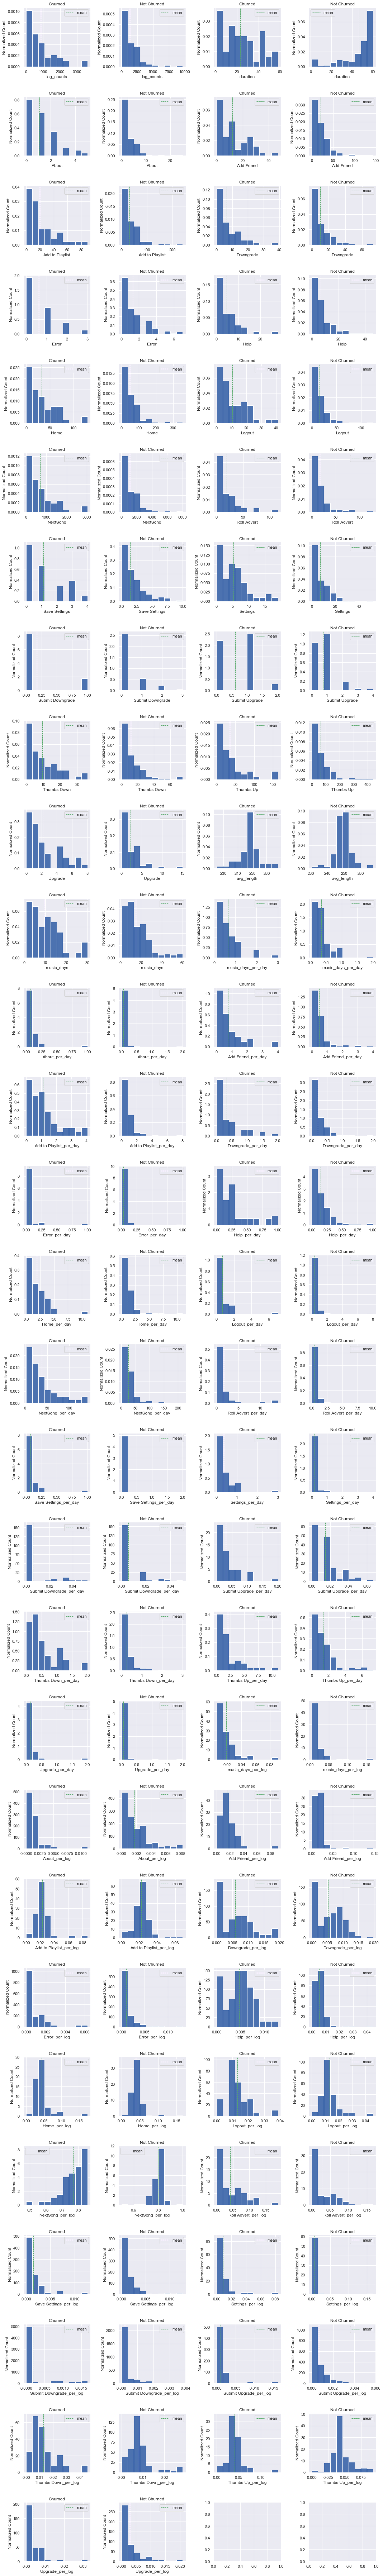

In [91]:
styler = plot_data(churned, not_churned, churned.columns[1:])

In [127]:
styler

,variable,churn,not_churn,diff,relative_diff
0,log_counts,862.769,1348.5,-485.728,-36.02
1,duration,23.2115,46.5376,-23.326,-50.12
2,About,1.07692,2.53757,-1.46065,-57.56
3,Add Friend,12.2308,21.0462,-8.81547,-41.89
4,Add to Playlist,19.9615,31.7225,-11.761,-37.07
5,Downgrade,6.48077,9.93064,-3.44987,-34.74
6,Error,0.615385,1.27168,-0.656292,-51.61
7,Help,4.59615,7.02312,-2.42697,-34.56
8,Home,32.1538,48.6127,-16.4589,-33.86
9,Logout,10.6346,15.4509,-4.81625,-31.17


In [133]:
html = styler.render()
import imgkit
imgkit.from_string(html, 'styled_table.png')

OSError: No wkhtmltoimage executable found: "b''"
If this file exists please check that this process can read it. Otherwise please install wkhtmltopdf - http://wkhtmltopdf.org
